# UKPN Constraint Location Analysis

This notebook analyzes the constraint descriptions from the UKPN real-time meter readings to map out constraint locations and understand the grid topology.


In [1]:
# Imports and setup
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set up paths
WORKDIR = "/Users/aron/project-overflow"
RT_CONSTRAINTS_PATH = os.path.join(WORKDIR, "ukpn-constraints-real-time-meter-readings.csv")
OUTPUT_DIR = os.path.join(WORKDIR, "outputs")

# Create outputs directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Verify file exists
assert os.path.exists(RT_CONSTRAINTS_PATH), f"Missing file: {RT_CONSTRAINTS_PATH}"

print("Setup complete. Ready to analyze constraints.")


Setup complete. Ready to analyze constraints.


In [2]:
# Load and examine the data
print("=" * 60)
print("LOADING CONSTRAINT DATA")
print("=" * 60)

# Load the real-time constraints data
rt_constraints = pd.read_csv(RT_CONSTRAINTS_PATH)
print(f"Loaded {len(rt_constraints)} real-time constraint readings")
print(f"Columns: {list(rt_constraints.columns)}")

# Show basic info about the dataset
print(f"\nDataset shape: {rt_constraints.shape}")
print(f"Date range: {rt_constraints['timestamp'].min()} to {rt_constraints['timestamp'].max()}")

# Extract unique constraint descriptions
unique_descriptions = rt_constraints['constraint_description'].unique()
print(f"\nFound {len(unique_descriptions)} unique constraint descriptions")

# Show a few examples
print("\nFirst 10 constraint descriptions:")
for i, desc in enumerate(unique_descriptions[:10]):
    print(f"{i+1:2d}. {desc}")


LOADING CONSTRAINT DATA
Loaded 159 real-time constraint readings
Columns: ['timestamp', 'constraint_id', 'current_amps', 'trim_limit_amps', 'release_limit_amps', 'breach_flag', 'constraint_description', 'der_name', 'utilisation_percentage']

Dataset shape: (159, 9)
Date range: 2025-08-26T22:20:00+00:00 to 2025-08-26T22:20:00+00:00

Found 159 unique constraint descriptions

First 10 constraint descriptions:
 1. Bramford 132kV  - BURY GRID tee STOWMARKET GRID 2 (EEPK  No. 2)
 2. Bramford 132kV - BURY GRID tee STOWMARKET GRID 1 (EEPK  No. 1)
 3. Lawford 132kV -  BRAMFORD GRID tee IPSWICH GRID 1 (PEC  No.1)
 4. Lawford 132kV -  CLACTON GRID 2 (PYA  No.2)
 5. Lawford 132kV - BRAMFORD GRID 4 (PJ)
 6. Lawford 132kV - SUM PYA Route
 7. ARBURY GRID 132/33kV - Milton 2 (PMK2)
 8. BURWELL MAIN GRID 132kV - SGT2
 9. EATON SOCON GRID 132kV - Corby Grid tee Huntingdon Grid 2 (PFZ route)
10. EATON SOCON GRID 132kV - Corby Grid tee Huntingdon Grid 1 (PFZ route)


In [3]:
# Parse constraint descriptions
print("=" * 60)
print("PARSING CONSTRAINT DESCRIPTIONS")
print("=" * 60)

# Parse constraint descriptions to extract key components
constraint_locations = []

for desc in unique_descriptions:
    # Extract voltage level
    voltage_match = re.search(r'(\d+)kV', desc)
    voltage = voltage_match.group(1) if voltage_match else 'Unknown'
    
    # Extract main location (before first dash)
    location_match = re.search(r'^([^-]+)', desc)
    location = location_match.group(1).strip() if location_match else 'Unknown'
    
    # Extract route codes in parentheses
    route_codes = re.findall(r'\(([^)]+)\)', desc)
    
    constraint_locations.append({
        'description': desc,
        'main_location': location,
        'voltage_kv': voltage,
        'route_codes': route_codes
    })

# Create DataFrame
locations_df = pd.DataFrame(constraint_locations)
print(f"Parsed {len(locations_df)} constraint descriptions")

# Show parsing results
print("\nParsing examples:")
print(locations_df.head(10))


PARSING CONSTRAINT DESCRIPTIONS
Parsed 159 constraint descriptions

Parsing examples:
                                         description            main_location  \
0  Bramford 132kV  - BURY GRID tee STOWMARKET GRI...           Bramford 132kV   
1  Bramford 132kV - BURY GRID tee STOWMARKET GRID...           Bramford 132kV   
2  Lawford 132kV -  BRAMFORD GRID tee IPSWICH GRI...            Lawford 132kV   
3        Lawford 132kV -  CLACTON GRID 2 (PYA  No.2)            Lawford 132kV   
4               Lawford 132kV - BRAMFORD GRID 4 (PJ)            Lawford 132kV   
5                      Lawford 132kV - SUM PYA Route            Lawford 132kV   
6             ARBURY GRID 132/33kV - Milton 2 (PMK2)     ARBURY GRID 132/33kV   
7                     BURWELL MAIN GRID 132kV - SGT2  BURWELL MAIN GRID 132kV   
8  EATON SOCON GRID 132kV - Corby Grid tee Huntin...   EATON SOCON GRID 132kV   
9  EATON SOCON GRID 132kV - Corby Grid tee Huntin...   EATON SOCON GRID 132kV   

  voltage_kv    route_

In [4]:
# Analyze locations
print("=" * 60)
print("LOCATION ANALYSIS")
print("=" * 60)

# Group by main location
location_summary = locations_df.groupby('main_location').agg({
    'voltage_kv': lambda x: list(set(x)),
    'route_codes': lambda x: list(set([code for codes in x for code in codes if codes])),
    'description': 'count'
}).rename(columns={'description': 'constraint_count'})

# Sort by constraint count
location_summary = location_summary.sort_values('constraint_count', ascending=False)

print(f"Total unique main locations: {len(location_summary)}")
print(f"Total constraints: {location_summary['constraint_count'].sum()}")
print(f"Average constraints per location: {location_summary['constraint_count'].mean():.1f}")

# Voltage level analysis
voltage_counts = locations_df['voltage_kv'].value_counts()
print(f"\nVoltage level distribution:")
for voltage, count in voltage_counts.items():
    print(f"  {voltage}kV: {count} constraints ({count/len(locations_df)*100:.1f}%)")

# Route codes analysis
all_route_codes = [code for codes in locations_df['route_codes'] for code in codes if codes]
route_counts = pd.Series(all_route_codes).value_counts()
print(f"\nTop 10 route codes:")
for route, count in route_counts.head(10).items():
    print(f"  {route}: {count} occurrences")


LOCATION ANALYSIS
Total unique main locations: 61
Total constraints: 159
Average constraints per location: 2.6

Voltage level distribution:
  33kV: 87 constraints (54.7%)
  132kV: 46 constraints (28.9%)
  UnknownkV: 17 constraints (10.7%)
  11kV: 9 constraints (5.7%)

Top 10 route codes:
  PFZ route: 3 occurrences
  AI route: 3 occurrences
  N constraint - Derived measurement: 2 occurrences
  PYA  No.1: 1 occurrences
  PMK1: 1 occurrences
  EEPB  No.2: 1 occurrences
  PI  No.1: 1 occurrences
  PCCB route: 1 occurrences
  HB route no.2: 1 occurrences
  HB route no.1: 1 occurrences


In [5]:
# Display top locations
print("=" * 60)
print("TOP CONSTRAINT LOCATIONS")
print("=" * 60)

print("Top 20 locations by constraint count:")
print("-" * 70)
for i, (location, row) in enumerate(location_summary.head(20).iterrows()):
    print(f'{i+1:2d}. {location:<30} ({row["constraint_count"]:2d} constraints)')
    print(f'    Voltages: {row["voltage_kv"]}')
    if row['route_codes']:
        print(f'    Routes: {row["route_codes"]}')
    print()

# Show locations with most route codes
locations_with_routes = location_summary[location_summary['route_codes'].apply(lambda x: len(x) > 0)]
print(f"\nLocations with route codes: {len(locations_with_routes)} out of {len(location_summary)}")
if len(locations_with_routes) > 0:
    print("\nTop 10 locations with most route codes:")
    route_counts_per_location = locations_with_routes.copy()
    route_counts_per_location['route_count'] = route_counts_per_location['route_codes'].apply(len)
    top_route_locations = route_counts_per_location.sort_values('route_count', ascending=False)
    
    for i, (location, row) in enumerate(top_route_locations.head(10).iterrows()):
        print(f'{i+1:2d}. {location:<30} ({row["route_count"]} routes, {row["constraint_count"]} constraints)')
        print(f'    Routes: {row["route_codes"]}')


TOP CONSTRAINT LOCATIONS
Top 20 locations by constraint count:
----------------------------------------------------------------------
 1. Bramford 132kV                 ( 9 constraints)
    Voltages: ['132']
    Routes: ['EEPK  No. 1', 'EEPB  No.2', 'EEPK  No. 2', 'PI  No.4', 'PI  No.1']

 2. Lawford 132kV                  ( 7 constraints)
    Voltages: ['132']
    Routes: ['PJ', 'PEC  No.1', 'PYA  No.2', 'PYA  No.1', 'PEC  No.3']

 3. ARBURY GRID 132/33kV           ( 6 constraints)
    Voltages: ['33']
    Routes: ['PMK2', 'PT No.2', 'PMK1', 'PT No1.']

 4. HISTON GRID 132/33kV           ( 6 constraints)
    Voltages: ['33']

 5. Norwich Main 132kV             ( 6 constraints)
    Voltages: ['132']

 6. Trowse Grid 132kV              ( 6 constraints)
    Voltages: ['132']

 7. PETERBOROUGH CENTRAL 132/33kV  ( 5 constraints)
    Voltages: ['33']

 8. Hempton Grid 132/33kV          ( 5 constraints)
    Voltages: ['33']

 9. Walpole 132kV                  ( 5 constraints)
    Voltages: [

In [6]:
# Save detailed analysis
print("=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Save detailed analysis
parsed_file = os.path.join(OUTPUT_DIR, 'constraint_locations_parsed.csv')
summary_file = os.path.join(OUTPUT_DIR, 'constraint_locations_summary.csv')

locations_df.to_csv(parsed_file, index=False)
location_summary.to_csv(summary_file)

print(f'Detailed analysis saved to: {parsed_file}')
print(f'Location summary saved to: {summary_file}')

# Also save the unique constraint descriptions for reference
desc_file = os.path.join(OUTPUT_DIR, 'constraint_descriptions.txt')
with open(desc_file, 'w') as f:
    for desc in sorted(unique_descriptions):
        f.write(desc + '\n')
        
print(f'Constraint descriptions saved to: {desc_file}')


SAVING RESULTS
Detailed analysis saved to: /Users/aron/project-overflow/outputs/constraint_locations_parsed.csv
Location summary saved to: /Users/aron/project-overflow/outputs/constraint_locations_summary.csv
Constraint descriptions saved to: /Users/aron/project-overflow/outputs/constraint_descriptions.txt


CREATING VISUALIZATIONS


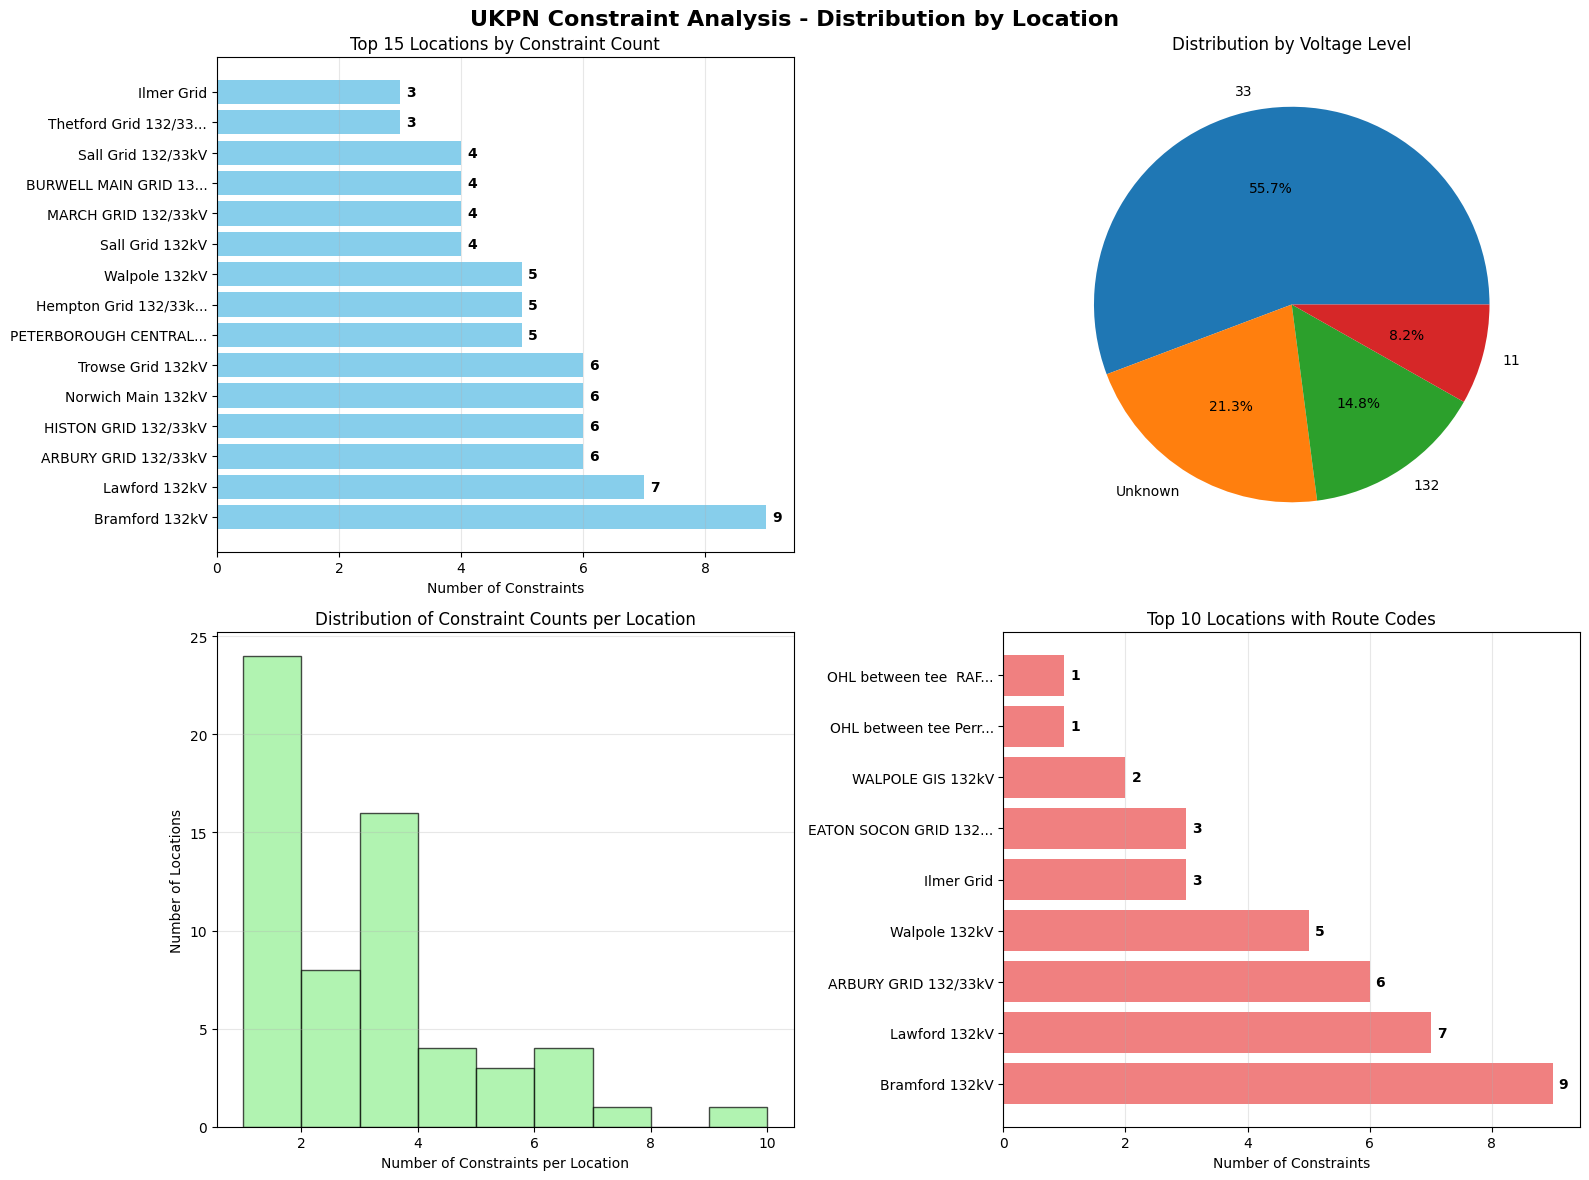

Charts saved to: /Users/aron/project-overflow/outputs/constraint_analysis_charts.png


In [7]:
# Create visualizations
print("=" * 60)
print("CREATING VISUALIZATIONS")
print("=" * 60)

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('UKPN Constraint Analysis - Distribution by Location', fontsize=16, fontweight='bold')

# 1. Top 15 locations by constraint count
top_15 = location_summary.head(15)
bars1 = ax1.barh(range(len(top_15)), top_15['constraint_count'], color='skyblue')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels([loc[:20] + '...' if len(loc) > 20 else loc for loc in top_15.index])
ax1.set_xlabel('Number of Constraints')
ax1.set_title('Top 15 Locations by Constraint Count')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.1, bar.get_y() + bar.get_height()/2, str(int(width)), 
             ha='left', va='center', fontweight='bold')

# 2. Voltage level distribution
voltage_counts = location_summary['voltage_kv'].apply(lambda x: x[0] if x else 'Unknown').value_counts()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
wedges, texts, autotexts = ax2.pie(voltage_counts.values, labels=voltage_counts.index, autopct='%1.1f%%', 
                                   colors=colors[:len(voltage_counts)])
ax2.set_title('Distribution by Voltage Level')

# 3. Constraint count distribution (histogram)
max_constraints = location_summary['constraint_count'].max()
bins = range(1, max_constraints + 2)
ax3.hist(location_summary['constraint_count'], bins=bins, 
         edgecolor='black', alpha=0.7, color='lightgreen')
ax3.set_xlabel('Number of Constraints per Location')
ax3.set_ylabel('Number of Locations')
ax3.set_title('Distribution of Constraint Counts per Location')
ax3.grid(axis='y', alpha=0.3)

# 4. Top locations with route codes
has_routes = location_summary[location_summary['route_codes'].apply(lambda x: len(x) > 0)].head(10)
if len(has_routes) > 0:
    bars4 = ax4.barh(range(len(has_routes)), has_routes['constraint_count'], color='lightcoral')
    ax4.set_yticks(range(len(has_routes)))
    ax4.set_yticklabels([loc[:20] + '...' if len(loc) > 20 else loc for loc in has_routes.index])
    ax4.set_xlabel('Number of Constraints')
    ax4.set_title('Top 10 Locations with Route Codes')
    ax4.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars4):
        width = bar.get_width()
        ax4.text(width + 0.1, bar.get_y() + bar.get_height()/2, str(int(width)), 
                 ha='left', va='center', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No locations with route codes', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Top 10 Locations with Route Codes')

plt.tight_layout()
chart_file = os.path.join(OUTPUT_DIR, 'constraint_analysis_charts.png')
plt.savefig(chart_file, dpi=300, bbox_inches='tight')
plt.show()
print(f'Charts saved to: {chart_file}')


In [8]:
# Summary statistics and conclusions
print("=" * 60)
print("CONSTRAINT LOCATION SUMMARY")
print("=" * 60)

print(f'Total locations: {len(location_summary)}')
print(f'Total constraints: {location_summary["constraint_count"].sum()}')
print(f'Average constraints per location: {location_summary["constraint_count"].mean():.1f}')
print(f'Locations with route codes: {len(location_summary[location_summary["route_codes"].apply(lambda x: len(x) > 0)])}')

print('\nTop 10 locations by constraint count:')
print('-' * 50)
for i, (location, row) in enumerate(location_summary.head(10).iterrows()):
    print(f'{i+1:2d}. {location:<30} ({row["constraint_count"]:2d} constraints)')

print('\nVoltage level breakdown:')
print('-' * 30)
voltage_summary = locations_df['voltage_kv'].value_counts().sort_index()
for voltage, count in voltage_summary.items():
    pct = count / len(locations_df) * 100
    print(f'{voltage}kV: {count:2d} constraints ({pct:4.1f}%)')

print('\nTop route codes:')
print('-' * 20)
all_routes = [code for codes in locations_df['route_codes'] for code in codes]
route_summary = pd.Series(all_routes).value_counts().head(10)
for route, count in route_summary.items():
    print(f'{route}: {count} occurrences')

print('\n' + '=' * 60)
print('ANALYSIS COMPLETE')
print('=' * 60)
print('Files created:')
print(f'  - {parsed_file}')
print(f'  - {summary_file}')
print(f'  - {desc_file}')
print(f'  - {chart_file}')
print('\nThis analysis provides the foundation for mapping constraint locations')
print('and understanding grid topology for the curtailment analysis.')


CONSTRAINT LOCATION SUMMARY
Total locations: 61
Total constraints: 159
Average constraints per location: 2.6
Locations with route codes: 9

Top 10 locations by constraint count:
--------------------------------------------------
 1. Bramford 132kV                 ( 9 constraints)
 2. Lawford 132kV                  ( 7 constraints)
 3. ARBURY GRID 132/33kV           ( 6 constraints)
 4. HISTON GRID 132/33kV           ( 6 constraints)
 5. Norwich Main 132kV             ( 6 constraints)
 6. Trowse Grid 132kV              ( 6 constraints)
 7. PETERBOROUGH CENTRAL 132/33kV  ( 5 constraints)
 8. Hempton Grid 132/33kV          ( 5 constraints)
 9. Walpole 132kV                  ( 5 constraints)
10. Sall Grid 132kV                ( 4 constraints)

Voltage level breakdown:
------------------------------
11kV:  9 constraints ( 5.7%)
132kV: 46 constraints (28.9%)
33kV: 87 constraints (54.7%)
UnknownkV: 17 constraints (10.7%)

Top route codes:
--------------------
PFZ route: 3 occurrences
AI route